# Data Download and Preprocessing

In [1]:
import kaggle as kg
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as f
import torchvision.transforms as T
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(20742)

%matplotlib inline 

C:\Programming\Anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if working on GPU
torch.cuda.is_available()

True

In [3]:
#--------------- If you are using Colab, run this code. ------------------
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
'''

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n    print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n        name=fn, length=len(uploaded[fn])))\n\n!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json\n'

In [4]:
# download the data using Kaggle API
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# unzip the downloaded file
from zipfile import ZipFile
file_name = 'digit-recognizer.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as ZIP:
  ZIP.extractall()

In [6]:
# load data to dataframe
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
# check the data
print(df_train.shape)
print(df_test.shape)
df_train.head()

(42000, 785)
(28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# transform dataframe to image size (C * H * W)
np_train_target = df_train.values[:, 0]
np_train_data = df_train.values[:, 1: (df_train.shape[1])].reshape(-1, 1, 28, 28)
np_test_data = df_test.values.reshape(-1, 1, 28, 28)
# transform numpy tp tensor
train_target = torch.tensor(np_train_target)
train_data = torch.tensor(np_train_data)
test_data = torch.tensor(np_test_data)
# check data shape once again
print(train_target.shape)
print(train_data.shape)
print(test_data.shape)

torch.Size([42000])
torch.Size([42000, 1, 28, 28])
torch.Size([28000, 1, 28, 28])


C:\Programming\Anaconda3\envs\Pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

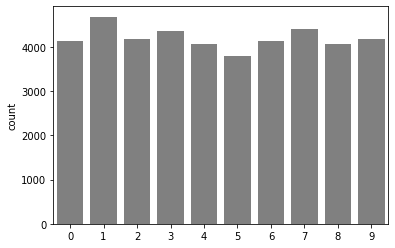

In [8]:
# check if it is an imbalanced data set
sns.countplot(np_train_target, color="grey")

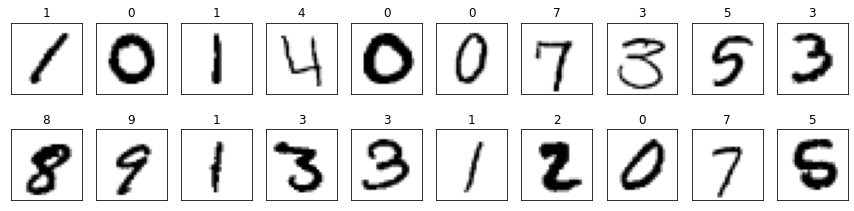

In [9]:
# plot a grid of images with titles of correct names and labels of predicted names
def plot(images, labels, predictions=None):
  # create a grid with 10 columns
  n_cols = min(10, len(images))
  n_rows = math.ceil(len(images) / n_cols)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.8))
  if predictions is None:
    predictions = [None] * len(labels)
  for index, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
    ax = axes.flat[index] # axes.flat is a numpy.flatiter
    ax.imshow(x[0, :, :], cmap=plt.cm.binary)
    ax.set_title(y_true.item())
    if y_pred is not None:
      ax.set_xlabel(y_pred)
    ax.set_xticks([])
    ax.set_yticks([])
# plot first 20 images
plot(train_data[:20], train_target[:20])

In [10]:
# min-max normalization
train_data = train_data / 255
test_data = test_data / 255
# cross validation
tra_data, val_data, tra_target, val_target = train_test_split(train_data, train_target, test_size=0.1)
print(tra_data.shape)
print(val_data.shape)

torch.Size([37800, 1, 28, 28])
torch.Size([4200, 1, 28, 28])


# Data augmentation

In [11]:
# create a tensor filled with uninitialized data
tra_data_trans = torch.empty(*list(tra_data.shape))
# rotate, zoom and shift images
for i in range(len(tra_data)):
    transform = T.Compose([T.RandomChoice([nn.Sequential(T.Pad(random.randint(0,2)), T.Resize((28,28))), # random zoom (smaller)
                nn.Sequential(T.CenterCrop(random.randint(26,28)), T.Resize((28,28)))]), # random zoom (bigger)
                T.RandomRotation((-10, 10)), # random rotation
                T.RandomAffine(degrees=0, translate=(0.1, 0.1))]) # random shift
    tra_data_trans[i] = transform((tra_data[i]))

### Previous images

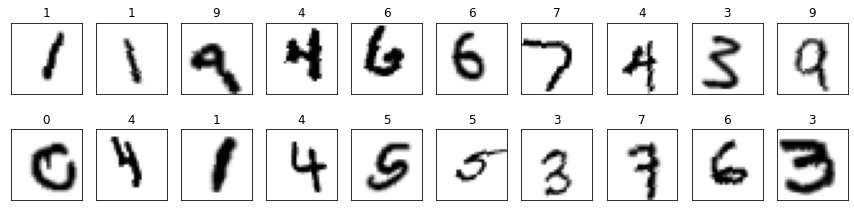

In [12]:
plot(tra_data_trans[:20], tra_target[:20])

### Augmented images

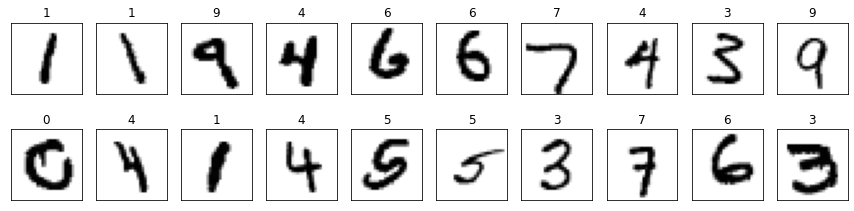

In [13]:
plot(tra_data[:20], tra_target[:20])

### Load our data set

In [14]:
batch = 70
# concatenate new data with original data
tra_data_aug = torch.cat((tra_data, tra_data_trans), dim=0)
tra_target_aug = torch.cat((tra_target, tra_target), dim=0)

tra_dataset = TensorDataset(tra_data_aug, tra_target_aug)
val_dataset = TensorDataset(val_data, val_target)

tra_loader = DataLoader(tra_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)

# CNN Model

### Define our model

In [15]:
epochs = 30
learning_rate = 0.001

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: (1, 28, 28) ------> output: (32, 14, 14)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, (5, 5), padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, (5, 5), padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2))
        )
        # input: (32, 14, 14) ------> output: (64, 7, 7)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3), padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, (3, 3), padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2))
        )
        # input: (64, 7, 7) ------> 3136 ------> output: 256
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5)
        )
        # input: 256  ------> output: 10
        self.fc2 = nn.Sequential(
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

### Train our model on splitted training data set

In [ ]:
cnn = CNN()
# implement Adam algorithm with learning rate
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay=1e-5) 
# set learning rate with schedule, reduce the learning rate by a factoer of 0.1 if loss has no improvement for 3 epochs
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=0.00001)
# this criterion computes the cross entropy loss between input and target
error = nn.CrossEntropyLoss()
for epoch in range(epochs):
    cumuloss_tra = 0 # initialize cumulative loss of training data set
    cumuloss_val = 0 # initialize cumulative loss of validation data set
    correct_tra = 0 # initialize cumulative correctness of training data set
    count_tra = 0 # initialize cumulative images of validation data set
    correct_val = 0 # initialize cumulative correctness of validation data set
    count_val = 0 # initialize cumulative images of validation data set
    
    cnn.train()
    for images, labels in tra_loader:
        outputs = cnn(images) # a list of probs in an output
        loss = error(outputs, labels)
        optimizer.zero_grad() # reset the gradient to 0
        loss.backward() # learn by backpropagation
        optimizer.step() # optimize weights
        predictions = torch.max(outputs, 1)[1] # predict using the maximum of an output
        correct_tra += (predictions == labels).sum().item() # cumulative correct predictions
        count_tra += len(labels) # total training samples
        cumuloss_tra += loss.item() # get the cumulative value of loss tensor
        
    cnn.eval()
    for images, labels in val_loader:
        outputs = cnn(images) # a list of probs in an output
        loss = error(outputs, labels)
        cumuloss_val += loss.item() 
        predictions = torch.max(outputs, 1)[1] # predict using the maximum of an output
        correct_val += (predictions == labels).sum().item() # cumulative correct predictions
        count_val += len(labels) # total training samples
    
    accuracy_tra = correct_tra / count_tra
    accuracy_val = correct_val / count_val
    loss_tra = cumuloss_tra/count_tra
    loss_val = cumuloss_val/count_val
    scheduler.step(loss_val)
    print(f'Epoch {epoch + 1}/{epochs} - train loss: {loss_tra:.12f} - accuracy: {accuracy_tra:.12f} - validation loss - {loss_val:.12f} - accuracy: {accuracy_val:.12f}')
    if loss_val >= 0.996:
        print("Early Stopping!")
        break

Epoch 1/30 - train loss: 0.021550616553 - accuracy: 0.964947089947 - validation loss - 0.021059485929 - accuracy: 0.988571428571
Epoch 2/30 - train loss: 0.021157732038 - accuracy: 0.982473544974 - validation loss - 0.021033658158 - accuracy: 0.989285714286


In [ ]:
# save our model
torch.save(cnn.state_dict(), 'BUDT737_Digit_Recognizer.pth')

In [ ]:
cnn.eval() # validation mode
val_label = []
val_pred = []
# using load_test is more efficient
for images, labels in val_loader: 
  # a contextmanager used to not track gradient calculations
    with torch.no_grad():
        prob = cnn(images)
        pred = torch.max(prob, 1)[1]
        val_label.extend(labels.numpy())
        val_pred.extend(pred.numpy())

In [ ]:
# plot the confusion matrix
cf_matrix = confusion_matrix(val_label, val_pred)
fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(cf_matrix, ax=ax, annot=True, cmap='Blues', fmt='g')
ax.set_ylabel('True label', fontsize=15)
ax.set_xlabel('Predicted label', fontsize=15)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# Prediction on test data set

In [ ]:
cnn.eval()
test_pred = torch.LongTensor()
for images in test_loader: 
    # a contextmanager used to not track gradient calculations
    with torch.no_grad():
        probs = cnn(images)
        preds = torch.max(probs, 1)[1]
        test_pred = torch.cat((test_pred, preds))

In [ ]:
# load our predictions into dataframe
preds = test_pred.numpy()
ids = np.array(range(len(test_pred))) + 1
submission = pd.DataFrame({'ImageId': ids, 'Label': preds}, columns=['ImageId', 'Label'])

In [ ]:
# check the submission
submission.head()

In [ ]:
submission.to_csv("C:\Downloads\Submission.csv", index = False)